# Official

Loss @ 4 => 0.083683: 100%|██████████| 5/5 [00:00<00:00, 63.32it/s]


0 -0.22157042 0.09369653
1 0.19698082 -0.43197381
2 0.4455318 0.36779612


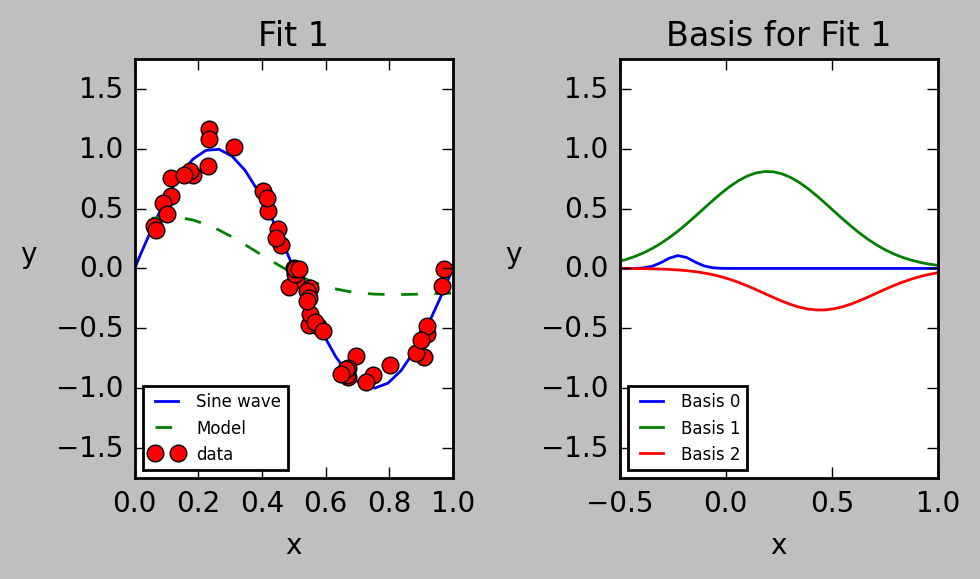

In [46]:
# Ravindra Bisram
# Modified example code from Professor Curro

import os
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Ended up removing the flags in order to use google colab
# Also removed the logging
from absl import app
from absl import flags
from tqdm import trange

from dataclasses import dataclass, field, InitVar

num_features = 1
num_samples = 50    # N
batch_size = 16
num_iters = 5000
learning_rate = 0.1
random_seed = 31415
sigma_noise = 0.1
debug = False
M = 3

font = {
    # "family": "Adobe Caslon Pro",
    "size": 10,
}

matplotlib.style.use("classic")
matplotlib.rc("font", **font)

"""
https://www.youtube.com/watch?v=CvQ7e6yUtnw --> dataclasses
-> The dataclass is a decorator that automatically creates the __init__ and __repr__ functions for us.
-> You can set the type of the variable, and also assign default values. Issue arises if you wanted to assign 
a default list, since every instance of the class would point to the same list. Get around this with the factory
function with the 'field(default_factory=list)' function.
-> field(init=False) --> That specific attribute cannot be assigned by the initializer!
-> InitVar https://docs.python.org/3/library/dataclasses.html#init-only-variables
-> Init-only fields are added as parameters to the generated __init__() method, 
and are passed to the optional __post_init__() method. They are not otherwise used by dataclasses.
"""
@dataclass
class LinearModel:
  weights: np.ndarray
  mews: np.ndarray
  sigmas: np.ndarray
  bias: float

@dataclass
class Data:
    rng: InitVar[np.random.Generator]
    num_features: int
    num_samples: int
    sigma: float
    x: np.ndarray = field(init=False)
    y: np.ndarray = field(init=False)

    def __post_init__(self, rng):
        self.index = np.arange(self.num_samples)
        self.x = rng.uniform(low=0.0, high=1.0, size=(self.num_samples, self.num_features))
        # y calues without the noise added in (perfect sine wave)
        self.clean_y = np.sin(np.pi*2*self.x)
        # Add the noise to the signal. Drawn from Normal distribution
        self.y = rng.normal(loc=self.clean_y, scale=self.sigma)

    def get_batch(self, rng, batch_size):
        """
        Select random subset of examples for training batch for SGD
        """
        choices = rng.choice(self.index, size=batch_size)

        return self.x[choices], self.y[choices].flatten()

# If you are going to make a class with tf variables that you are interested in optimizing, you 
# need to make it a tf.Module. It let's tf.gradient tape find the trainable variables
class LinearGaussianModel(tf.Module):
    def __init__(self, rng, num_features, M):
        """
        Extended original simple linear model to include a Gaussian term that now takes into 
        account non-linearities. There are now 4 trainable parameters. 
        """
        self.num_features = num_features
        self.M = M
        self.weights = tf.Variable(rng.normal(shape=[self.M, 1]))
        #self.mews = tf.Variable(rng.normal(shape=[self.M, 1]))
        #self.sigmas = tf.Variable(rng.normal(shape=[self.M, 1]))
        self.mews = tf.Variable(rng.normal(shape=[1, self.M]))
        self.sigmas = tf.Variable(rng.normal(shape=[1, self.M]))
        self.bias = tf.Variable(tf.zeros(shape=[1, 1]))

    # When an instance of the class is called like a function, this method goes off
    # Returns the y_hat
    def __call__(self, x):
      return tf.squeeze(tf.math.exp((-(x-self.mews)**2) / (self.sigmas)**2) @ self.weights + self.bias)
      """
      Notes from office hours
      X -> (NUM_SAMPLES, 1)
      nUM_SAMPLES = 50
      WEIGHTS, SIGMAS, MEWS = 1, m
      bias = 1
      -> broadcasting
      """
      """
      return tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[0])) / tf.math.square(self.sigmas[0])) * self.weights[0]) + \
        tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[1])) / tf.math.square(self.sigmas[1])) * self.weights[1]) + \
        tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[2])) / tf.math.square(self.sigmas[2])) * self.weights[2]) + \
            self.bias
      """
      """
      output = tf.zeros([1,])
      for i in range(M):
        output = tf.add(output, tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[i])) / tf.math.square(self.sigmas[i])) * self.weights[i]))

      return tf.squeeze(tf.add(output, self.bias))      
      """
    
    # Basically a getter
    @property
    def model(self):
        return LinearModel(
            self.weights.numpy(), 
            self.mews.numpy(), 
            self.sigmas().numpy(), 
            self.b.numpy().squeeze()
        )
    
def main():
  # Safe np and tf PRNG
  seed_sequence = np.random.SeedSequence(random_seed)
  np_seed, tf_seed = seed_sequence.spawn(2)
  np_rng = np.random.default_rng(np_seed)
  tf_rng = tf.random.Generator.from_seed(tf_seed.entropy)

  data = Data(
    np_rng,
    num_features,
    num_samples,
    sigma_noise,
  )

  # Generate the model
  gaussian_model = LinearGaussianModel(tf_rng, num_features, M=M)

  optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

  bar = trange(num_iters)
  for i in bar:
      with tf.GradientTape() as tape:
        x, y = data.get_batch(np_rng, batch_size)
        y_hat = gaussian_model(x)
        loss = 0.5 * tf.reduce_mean((y_hat - y) ** 2)

      grads = tape.gradient(loss, gaussian_model.trainable_variables)
      optimizer.apply_gradients(zip(grads, gaussian_model.trainable_variables))

      bar.set_description(f"Loss @ {i} => {loss.numpy():0.6f}")
      bar.refresh()
  
  
  #print(data.x, data.y)
  X_LOW = -1
  Y_LOW = -(np.amax(data.y) * 1.5)
  Y_HIGH = np.amax(data.y) * 1.5
  fig, ax = plt.subplots(1, 2, figsize=(5, 3), dpi=200)
  
  ax[0].set_title("Fit 1")
  ax[0].set_xlabel("x")
  ax[0].set_ylim(Y_LOW, Y_HIGH)
  ax[0].set_xlim(0, 1)
  h1 = ax[0].set_ylabel("y", labelpad=10)
  h1.set_rotation(0)
  
  xs = np.linspace(X_LOW, 1, num_samples)
  xs = xs[:, np.newaxis]

  # Was having a problem with graphing the actual sine wave for some reason 
  # https://stackoverflow.com/questions/37116626/python-maplotlib-sine-curve-with-random-randn
  sortx = np.argsort(np.squeeze(data.x))

  ax[0].plot(xs, np.sin(np.pi*2*xs), label='Sine wave')
  #ax.plot(np.squeeze(data.x[sortx]), data.clean_y[sortx])
  ax[0].plot(xs, np.squeeze(gaussian_model(xs)), "--", label='Model')   # Noisy Gaussian Model
  ax[0].plot(np.squeeze(data.x), data.y, "o", label='data')            # Data points 
  ax[0].legend(loc='lower left', prop={'size': 6})

  
  # Plotting the basis functions 
  ax[1].set_title("Basis for Fit 1", fontsize=12)
  ax[1].set_xlim(-0.5,1)
  ax[1].set_xlabel("x")
  ax[1].set_xticks([-0.5, 0, 0.5, 1])
  ax[1].set_ylim(Y_LOW, Y_HIGH)
  h2 = ax[1].set_ylabel("y", labelpad=10)
  h2.set_rotation(0)
  
  mu = gaussian_model.mews.numpy()[0]
  #print(mu)
  sig = gaussian_model.sigmas.numpy()[0]
  #print(sig)
  
  xs = np.squeeze(tf.cast(xs, tf.float32))

  for i in range(M):
    print(i, mu[i], sig[i])
    ax[1].plot(xs, np.squeeze(tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(xs, mu[i])) / tf.math.square(sig[i]))* gaussian_model.weights[i])), label=f'Basis {i}')
    ax[1].legend(loc='lower left', prop={'size': 6})

  plt.tight_layout()
  plt.show()
  

main()

# Testing

# Original


Loss @ 299 => 0.120766: 100%|██████████| 300/300 [00:06<00:00, 43.29it/s]


w,    w_hat
1.00, 1.30
2.00, 1.88


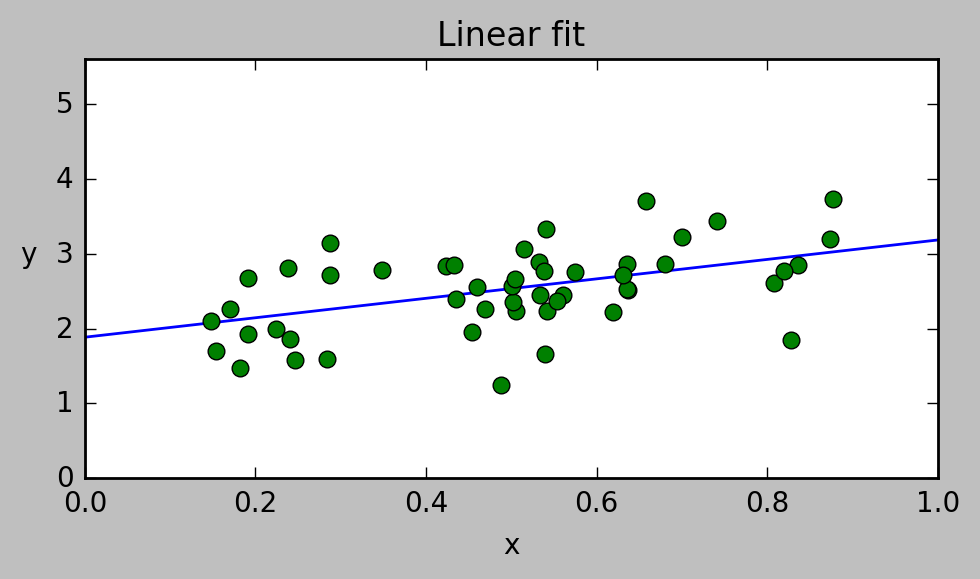

In [ ]:
#!/bin/env python3.8

"""
Example assignment. Author: Chris Curro
"""
import os
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from absl import app
from absl import flags
from tqdm import trange

from dataclasses import dataclass, field, InitVar

# script_path = os.path.dirname(os.path.realpath(__file__))

"""
https://www.youtube.com/watch?v=CvQ7e6yUtnw --> dataclasses
-> The dataclass is a decorator that automatically creates the __init__ and __repr__ functions for us.
-> You can set the type of the variable, and also assign default values. Issue arises if you wanted to assign 
a default list, since every instance of the class would point to the same list. Get around this with the factory
function with the 'field(default_factory=list)' function.
-> field(init=False) --> That specific attribute cannot be assigned by the initializer!
-> InitVar https://docs.python.org/3/library/dataclasses.html#init-only-variables
-> Init-only fields are added as parameters to the generated __init__() method, 
and are passed to the optional __post_init__() method. They are not otherwise used by dataclasses.
"""
@dataclass
class LinearModel:
    weights: np.ndarray
    bias: float


@dataclass
class Data:
    model: LinearModel
    rng: InitVar[np.random.Generator]
    num_features: int
    num_samples: int
    sigma: float
    x: np.ndarray = field(init=False)
    y: np.ndarray = field(init=False)

    def __post_init__(self, rng):
        self.index = np.arange(self.num_samples)
        self.x = rng.uniform(0.1, 0.9, size=(self.num_samples, self.num_features))
        clean_y = self.x @ self.model.weights[:, np.newaxis] + self.model.bias
        self.y = rng.normal(loc=clean_y, scale=self.sigma)

    def get_batch(self, rng, batch_size):
        """
        Select random subset of examples for training batch
        """
        choices = rng.choice(self.index, size=batch_size)

        return self.x[choices], self.y[choices].flatten()


def compare_linear_models(a: LinearModel, b: LinearModel):
    for w_a, w_b in zip(a.weights, b.weights):
        print(f"{w_a:0.2f}, {w_b:0.2f}")

    print(f"{a.bias:0.2f}, {b.bias:0.2f}")


font = {
    # "family": "Adobe Caslon Pro",
    "size": 10,
}

matplotlib.style.use("classic")
matplotlib.rc("font", **font)

num_features = 1
num_samples = 50
batch_size = 16
num_iters = 300
learning_rate = 0.1
random_seed = 31415
sigma_noise = 0.5
debug = False

class Model(tf.Module):
    def __init__(self, rng, num_features):
        """
        A plain linear regression model with a bias term
        """
        self.num_features = num_features
        self.w = tf.Variable(rng.normal(shape=[self.num_features, 1]))
        self.mean = tf.Variable(rng.normal(shape=[self.num_features, 1]))
        self.stddev = tf.Variable(rng.normal(shape=[self.num_features, 1]))
        self.b = tf.Variable(tf.zeros(shape=[1, 1]))

    def __call__(self, x):
        return tf.squeeze(x @ self.w + self.b)

    @property
    def model(self):
        return LinearModel(
            self.w.numpy().reshape([self.num_features]), self.b.numpy().squeeze()
        )

def main(a):
    # Safe np and tf PRNG
    seed_sequence = np.random.SeedSequence(random_seed)
    np_seed, tf_seed = seed_sequence.spawn(2)
    np_rng = np.random.default_rng(np_seed)
    tf_rng = tf.random.Generator.from_seed(tf_seed.entropy)

    data_generating_model = LinearModel(
        weights=np_rng.integers(low=0, high=5, size=(num_features)), bias=2
    )
    

    data = Data(
        data_generating_model,
        np_rng,
        num_features,
        num_samples,
        sigma_noise,
    )

    model = Model(tf_rng, num_features)

    optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

    bar = trange(num_iters)
    for i in bar:
        with tf.GradientTape() as tape:
            x, y = data.get_batch(np_rng, batch_size)
            y_hat = model(x)
            loss = 0.5 * tf.reduce_mean((y_hat - y) ** 2)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        bar.set_description(f"Loss @ {i} => {loss.numpy():0.6f}")
        bar.refresh()


    # print out true values versus estimates
    print("w,    w_hat")
    compare_linear_models(data.model, model.model)

    if num_features > 1:
        # Only continue to plotting if x is a scalar
        exit(0)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

    ax.set_title("Linear fit")
    ax.set_xlabel("x")
    ax.set_ylim(0, np.amax(data.y) * 1.5)
    h = ax.set_ylabel("y", labelpad=10)
    h.set_rotation(0)

    xs = np.linspace(0, 1, 10)
    xs = xs[:, np.newaxis]
    ax.plot(xs, np.squeeze(model(xs)), "-", np.squeeze(data.x), data.y, "o")

    plt.tight_layout()
    # plt.savefig(f"{script_path}/fit.pdf")


main(2)
